# Dataset

In [1]:
from pathlib import Path

def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))

In [2]:
!pip install -q wandb tqdm matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import wandb
wandb.login(key='6b22cbf359c5924f4500afc1ae572d6827998186', relogin=True, force=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import wandb
from tqdm import tqdm as progress_bar

# from cloud_diffusion.utils import ls

PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'maidacundo/cloud_diffusion/sample_dataset:v0'

class DummyNextFrameDataset:
    "Dataset that returns random images"
    def __init__(self, num_frames=4, img_size=64, N=1000):
        self.img_size = img_size
        self.num_frames = num_frames
        self.N = N

    def __getitem__(self, idx):
        return torch.randn(self.num_frames, self.img_size, self.img_size)
    
    def __len__(self):
        return self.N


class CloudDataset:
    """Dataset for cloud images
    It loads numpy files from wandb artifact and stacks them into a single array
    It also applies some transformations to the images
    """
    def __init__(self, 
                 files, # list of numpy files to load (they come from the artifact)
                 num_frames=4, # how many consecutive frames to stack
                 scale=True, # if we images to interval [-0.5, 0.5]
                 img_size=64, # resize dim, original images are big (446, 780)
                 valid=False, # if True, transforms are deterministic
                ):
        
        tfms = [T.Resize((img_size, int(img_size*1.7)), antialias=True)] if img_size is not None else []
        tfms += [T.RandomCrop(img_size)] if not valid else [T.CenterCrop(img_size)]
        self.tfms = T.Compose(tfms)
        self.load_data(files, num_frames, scale)
        
    def load_day(self, file, scale=True):
        one_day = np.load(file)
        one_day = one_day.astype('float32')
        if scale:
            one_day = 0.5 - self._scale(one_day)
        return one_day

    def load_data(self, files, num_frames, scale):
        "Loads all data into a single array self.data"
        data = []
        # TODO: download all files
        for file in progress_bar(files, leave=False):
            one_day = self.load_day(file, scale)
            wds = np.lib.stride_tricks.sliding_window_view(
                one_day.squeeze(),
                num_frames,
                axis=0).transpose((0,3,1,2))
            data.append(wds)
            # pbar.comment = f"Creating CloudDataset from {file}"
        self.data = np.concatenate(data, axis=0)

    def shuffle(self):
        """Shuffles the dataset, useful for getting 
        interesting samples on the validation dataset"""
        idxs = torch.randperm(len(self.data))
        self.data = self.data[idxs]
        return self

    @staticmethod
    def _scale(arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)
    
    def __getitem__(self, idx):
        return self.tfms(torch.from_numpy(self.data[idx]))
    
    def __len__(self): return len(self.data)

    def save(self, fname="cloud_frames.npy"):
        np.save(fname, self.data)


class CloudDatasetInference(CloudDataset):
     def load_data(self, files, num_frames=None, scale=None):
        "Loads all data into a single array self.data"
        data = []
        max_length = 100
        # TODO: download everything
        for file in files:
            one_day = self.load_day(file, scale)
            data.append(one_day)
            max_length = min(max_length, len(one_day))
        self.data = np.stack([d[:max_length] for d in data], axis=0).squeeze()


def download_dataset(at_name, project_name):
    "Downloads dataset from wandb artifact"
    def _get_dataset(run):
        artifact = run.use_artifact(at_name, type='dataset')
        return artifact.download()

    if wandb.run is not None:
        run = wandb.run
        artifact_dir = _get_dataset(run)
    else:
        run = wandb.init(project=project_name, job_type="download_dataset")
        artifact_dir = _get_dataset(run)
        run.finish()

    files = ls(Path(artifact_dir))
    return files


In [5]:
files = download_dataset(DATASET_ARTIFACT, project_name=PROJECT_NAME)
train_ds = CloudDataset(files)
print(f"Let's grab 5 samples: {train_ds[0:5].shape}")

wandb: Currently logged in as: maidacundo. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact sample_dataset:v0, 360.00MB. 30 files... 
wandb:   30 of 30 files downloaded.  
Done. 0:0:0.7


Let's grab 5 samples: torch.Size([5, 4, 64, 64])


In [6]:
train_ds[0].shape

torch.Size([4, 64, 64])

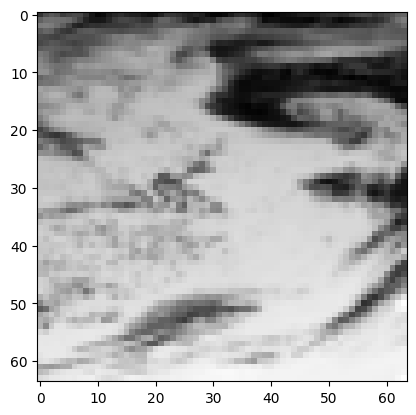

In [7]:
# Show the first sample image of the training dataset
import matplotlib.pyplot as plt

plt.imshow(train_ds[0][0], cmap='gray')

# Model

In [8]:
!pip install diffusers


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [9]:
!pip install denoising_diffusion_pytorch


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [10]:
!pip install fastcore 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
from typing import Tuple
import torch
from torch import nn

class TemporalEncoder(nn.Module):
    def __init__(
        self, 
        input_size: Tuple[int, int], 
        hidden_size: int,
        num_images: int, 
        device: str
        ) -> None:
        super().__init__()
        # Set the input size of the image.
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Set the size of the flattened image.
        self.flatten_size = input_size[0] * input_size[1]
        # Set a list of GRUs, one for each image.
        self.gru = nn.GRU(
            self.flatten_size, hidden_size, num_layers=num_images,
            batch_first=True)
        #self.grus = nn.ModuleList(
        #    [nn.GRU(self.flatten_size, self.flatten_size)
        #     for _ in range(num_images)])
        # Set the device used for the computations.
        self.to(device)
        self.device = device

    def to(self, device: str) -> None:
        super().to(device)
        self.device = device

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        batch_size = x.shape[0]
        n_channels = x.shape[1]
        # Set the initial hidden states 
        initial_hidden_state = torch.zeros(
            batch_size, n_channels, self.flatten_size, dtype=torch.float32,
            device=self.device)

        _, out = self.gru(x.flatten(start_dim=2), initial_hidden_state)
        # Iterate over the images and pass them through the GRUs.
        '''for i, gru in enumerate(self.grus):
            # Flatten the image.
            img = x[:, i].flatten(start_dim=1)
            # If it is the first image, use the initial hidden state.
            if i == 0:
                h = initial_hidden_state
            # Get the forward pass of the GRU.
            h, _ = gru(img, h)''';
        
        """# Turn the hidden state to the original shape.
        out = out.view(batch_size, n_channels, self.input_size[0],
                       self.input_size[1])"""
        return out

In [11]:
from pathlib import Path

import wandb
import fastcore.all as fc

import torch
from torch import nn
from diffusers import UNet2DConditionModel

try:
    from denoising_diffusion_pytorch.simple_diffusion import UViT
except:
    raise ImportError("Please install denoising_diffusion_pytorch with `pip install denoising_diffusion_pytorch`")


def init_unet(model):
    "From Jeremy's bag of tricks on fastai V2 2023"
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): nn.init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

class WandbModel:
    "A model that can be saved to wandb"
    @classmethod
    def from_checkpoint(cls, model_params, checkpoint_file):
        "Load a UNet2D model from a checkpoint file"
        model = cls(**model_params)
        print(f"Loading model from: {checkpoint_file}")
        model.load_state_dict(torch.load(checkpoint_file))
        return model

    @classmethod
    def from_artifact(cls, model_params, artifact_name):
        "Load a UNet2D model from a wandb.Artifact, need to be run in a wandb run"
        artifact = wandb.use_artifact(artifact_name, type='model')
        artifact_dir = Path(artifact.download())
        chpt_file = list(artifact_dir.glob("*.pth"))[0]
        return cls.from_checkpoint(model_params, chpt_file)

def get_unet_params(model_name="unet_small", num_frames=4):
    "Return the parameters for the diffusers UNet2d model"
    if model_name == "unet_small":
        return dict(
            block_out_channels=(16, 32, 64, 128), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    elif model_name == "unet_big":
        return dict(
            block_out_channels=(32, 64, 128, 256), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'unet_small' or 'unet_big'")

class UNet2DTemporalCondition(UNet2DConditionModel, WandbModel):
    def __init__(self, 
                 *x, 
                 input_size: Tuple[int, int], 
                 hidden_size: int, 
                 num_images: int, 
                 device: str = "cuda",
                 **kwargs):
        super().__init__(*x, **kwargs)
        init_unet(self)
        self.temporal_encoder = TemporalEncoder(input_size=input_size, hidden_size=hidden_size, num_images=num_images, device=device)

    def forward(self, *x, **kwargs):
        print(type(x))
        encoder_hidden_states= self.temporal_encoder(*x)
        return super().forward(*x, encoder_hidden_states=encoder_hidden_states, **kwargs).sample ## Diffusers's UNet2DConditionModel class

## Simple Diffusion paper

def get_uvit_params(model_name="uvit_small", num_frames=4):
    "Return the parameters for the diffusers UViT model"
    if model_name == "uvit_small":
        return dict(
            dim=512,
            ff_mult=2,
            vit_depth=4,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    elif model_name == "uvit_big":
        return dict(
            dim=1024,
            ff_mult=4,
            vit_depth=8,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'uvit_small' or 'uvit_big'")

class UViTModel(UViT, WandbModel): pass

In [12]:
from pathlib import Path

import torch
import wandb
import numpy as np

## For Training

def to_wandb_image(img):
    "Convert a tensor to a wandb.Image"
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

def log_images(xt, samples):
    "Log sampled images to wandb"
    device = samples.device
    frames = torch.cat([xt[:, :-1,...].to(device), samples], dim=1)
    wandb.log({"sampled_images": [to_wandb_image(img) for img in frames]})

def save_model(model, model_name):
    "Save the model to wandb"
    model_name = f"{wandb.run.id}_{model_name}"
    models_folder = Path("models")
    if not models_folder.exists():
        models_folder.mkdir()
    torch.save(model.state_dict(), models_folder/f"{model_name}.pth")
    at = wandb.Artifact(model_name, type="model")
    at.add_file(f"models/{model_name}.pth")
    wandb.log_artifact(at)


## For Inference
def htile(img):
    "Horizontally tile a batch of images."
    return torch.cat(img.split(1), dim=-1)

def vtile(img):
    "Vertically tile a batch of images."
    return torch.cat(img.split(1), dim=-2)

def vhtile(*imgs):
    "Vertically and horizontally tile a batch of images."
    return vtile(torch.cat([htile(img) for img in imgs], dim=0))

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    "Preprocess frames for wandb.Video"
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

In [13]:
!pip install fastprogress torchmetrics


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [22]:
import random, argparse
from pathlib import Path

import wandb
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data.dataloader import default_collate
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from fastprogress import progress_bar

#from cloud_diffusion.wandb import log_images, save_model

def noisify_last_frame(frames, noise_func):
    "Noisify the last frame of a sequence"
    past_frames = frames[:,:-1]
    last_frame  = frames[:,-1:]
    noise, t, e = noise_func(last_frame)
    return torch.cat([past_frames, noise], dim=1), t, e

def noisify_collate(noise_func): 
    def _inner(b): 
        "Collate function that noisifies the last frame"
        return noisify_last_frame(default_collate(b), noise_func)
    return _inner

class NoisifyDataloader(DataLoader):
    """Noisify the last frame of a dataloader by applying 
    a noise function, after collating the batch"""
    def __init__(self, dataset, *args, noise_func=None, **kwargs):
        super().__init__(dataset, *args, collate_fn=noisify_collate(noise_func), **kwargs)

class MiniTrainer:
    "A mini trainer for the diffusion process"
    def __init__(self, 
                 train_dataloader, 
                 valid_dataloader, 
                 model, 
                 sampler, 
                 device="cuda", 
                 loss_func=nn.MSELoss(), 
                 ):
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.loss_func = loss_func
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        self.model = model.to(device)
        self.scaler = torch.cuda.amp.GradScaler()
        self.device = device
        self.sampler = sampler
        self.val_batch = next(iter(valid_dataloader))[0].to(device)  # grab a fixed batch to log predictions
    
    def train_step(self, loss):
        "Train for one step"
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.scheduler.step()

    def one_epoch(self, epoch=None):
        "Train for one epoch, log metrics and save model"
        self.model.train()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for batch in pbar:
            frames, t, noise = to_device(batch, device=self.device)
            with torch.autocast("cuda"):
                predicted_noise = self.model(frames, t)
                loss = self.loss_func(noise, predicted_noise)
            self.train_step(loss)
            wandb.log({"train_mse": loss.item(),
                       "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"epoch={epoch}, MSE={loss.item():2.3f}"

    def one_epoch_validation(self, epoch=None):
        "Validates on val set"
        pbar = progress_bar(self.valid_dataloader, leave=False)
        psnr_metric = 0
        mse_metric = 0
        ssmi_metric = 0
        for val_batch in pbar:
            frames = val_batch[0].to(self.device)
            samples = self.sampler(self.model, past_frames=frames[:,:-1]).to(self.device)
            psnr_metric += self.psnr(samples, frames[:,-1]).float().cpu()
            ssmi_metric += self.ssim(samples, frames[:,-1]).float().cpu()
            mse_metric += self.loss_func(samples, frames[:,-1]).float().cpu()
        psnr_metric = psnr_metric / len(self.valid_dataloader)
        ssmi_metric = ssmi_metric / len(self.valid_dataloader)
        mse_metric = mse_metric / len(self.valid_dataloader)
        wandb.log({"val_psnr": psnr_metric,
                   "val_ssmi": ssmi_metric,
                   "val_mse": mse_metric})

    def prepare(self, config):
        wandb.config.update(config)
        config.total_train_steps = config.epochs * len(self.train_dataloader)
        self.optimizer = AdamW(self.model.parameters(), lr=config.lr, eps=1e-5)
        self.scheduler = OneCycleLR(self.optimizer, max_lr=config.lr, total_steps=config.total_train_steps)

    def fit(self, config):
        self.prepare(config)
        self.val_batch = self.val_batch[:min(config.n_preds, 8)]  # log first 8 predictions
        for epoch in progress_bar(range(config.epochs), total=config.epochs, leave=True):
            self.one_epoch(epoch)
            self.one_epoch_validation(epoch)
            
            # log predictions
            if epoch % config.log_every_epoch == 0:
                samples = self.sampler(self.model, past_frames=self.val_batch[:,:-1])
                log_images(self.val_batch, samples)

        save_model(self.model, config.model_name)


def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def to_device(t, device="cpu"):
    if isinstance(t, (tuple, list)):
        return [_t.to(device) for _t in t]
    elif isinstance(t, torch.Tensor):
        return t.to(device)
    else:
        raise("Not a Tensor or list of Tensors")


def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))


def parse_args(config):
    "A brute force way to parse arguments, it is probably not a good idea to use it"
    parser = argparse.ArgumentParser(description='Run training baseline')
    for k,v in config.__dict__.items():
        parser.add_argument('--'+k, type=type(v), default=v)
    args = vars(parser.parse_args())
    
    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)

In [15]:
from functools import partial

import torch
from fastprogress import progress_bar

from diffusers.schedulers import DDIMScheduler


## DDPM params
## From fastai V2 Course DDPM notebooks
betamin,betamax,n_steps = 0.0001,0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

def noisify_ddpm(x0):
    "Noise by ddpm"
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

@torch.no_grad()
def diffusers_sampler(model, past_frames, sched, **kwargs):
    "Using Diffusers built-in samplers"
    model.eval()
    device = next(model.parameters()).device
    new_frame = torch.randn_like(past_frames[:,-1:], dtype=past_frames.dtype, device=device)
    preds = []
    pbar = progress_bar(sched.timesteps, leave=False)
    for t in pbar:
        pbar.comment = f"DDIM Sampler: frame {t}"
        noise = model(torch.cat([past_frames, new_frame], dim=1), t)
        new_frame = sched.step(noise, t, new_frame, **kwargs).prev_sample
        preds.append(new_frame.float().cpu())
    return preds[-1]

def ddim_sampler(steps=350, eta=1.):
    "DDIM sampler, faster and a bit better than the built-in sampler"
    ddim_sched = DDIMScheduler()
    ddim_sched.set_timesteps(steps)
    return partial(diffusers_sampler, sched=ddim_sched, eta=eta)

In [16]:
from pathlib import Path
from types import SimpleNamespace

import wandb
import torch
from torch.utils.data import DataLoader

# from cloud_diffusion.dataset import download_dataset, CloudDataset
#from cloud_diffusion.utils import NoisifyDataloader, MiniTrainer, set_seed, parse_args
#from cloud_diffusion.ddpm import noisify_ddpm, ddim_sampler
# from cloud_diffusion.models import UNet2D, get_unet_params


PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'maidacundo/cloud_diffusion/sample_dataset:v0'

config = SimpleNamespace(    
    epochs=50, # number of epochs
    model_name="unet_small", # model name to save [unet_small, unet_big]
    strategy="ddpm", # strategy to use ddpm
    noise_steps=1000, # number of noise steps on the diffusion process
    sampler_steps=333, # number of sampler steps on the diffusion process
    seed=42, # random seed
    batch_size=128, # batch size
    img_size=64, # image size
    device="cuda", # device
    num_workers=8, # number of workers for dataloader
    num_frames=4, # number of frames to use as input
    lr=5e-4, # learning rate
    validation_days=3, # number of days to use for validation
    log_every_epoch=5, # log every n epochs to wandb
    n_preds=8, # number of predictions to make
    )

def train_func(config):
    config.model_params = get_unet_params(config.model_name, config.num_frames)

    set_seed(config.seed)
    device = torch.device(config.device)

    # downlaod the dataset from the wandb.Artifact
    files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)
    train_days, valid_days = files[:-config.validation_days], files[-config.validation_days:]
    train_ds = CloudDataset(files=train_days, num_frames=config.num_frames, img_size=config.img_size)
    valid_ds = CloudDataset(files=valid_days, num_frames=config.num_frames, img_size=config.img_size).shuffle()

    # DDPM dataloaders
    train_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=True, 
                                         noise_func=noisify_ddpm,  num_workers=config.num_workers)
    valid_dataloader = NoisifyDataloader(valid_ds, config.batch_size, shuffle=False, 
                                          noise_func=noisify_ddpm,  num_workers=config.num_workers)

    # model setup
    model = UNet2D(**config.model_params)

    # sampler
    sampler = ddim_sampler(steps=config.sampler_steps)

    # A simple training loop
    trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)
    trainer.fit(config)

In [ ]:
with wandb.init(project=PROJECT_NAME, entity='ai-industry', config=config, tags=["ddpm", config.model_name]):
    train_func(config)

wandb: Downloading large artifact sample_dataset:v0, 360.00MB. 30 files... 
wandb:   30 of 30 files downloaded.  
Done. 0:0:0.2
